# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
'''
Anpassen: 

number_of_variables --> anzahl variablen

lambda_dataset_size --> datensatz größe für training von lambda-nets
number_of_generated_datasets and  number_of_trained_lambda_nets --> anzahl der lambda-nets

lambda_network_layers --> structure of lambda net (automatically generated)
(generell in lambda_net bei config steht alles um die structure der lambda-nets anzupassen, dass es identisch zu logistic regression ist)


'''

'\nAnpassen: \n\nnumber_of_variables --> anzahl variablen\n\nlambda_dataset_size --> datensatz größe für training von lambda-nets\nnumber_of_generated_datasets and  number_of_trained_lambda_nets --> anzahl der lambda-nets\n\nlambda_network_layers --> structure of lambda net (automatically generated)\n(generell in lambda_net bei config steht alles um die structure der lambda-nets anzupassen, dass es identisch zu logistic regression ist)\n\n\n'

In [2]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'exclude_linearly_seperable': False,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'function_generation_type': 'make_classification' ,#'distribution', 'distribution_trained' 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],#['uniform', 'normal', 'gamma', 'beta', 'poisson', 'lognormal', 'exponential', 'f', 'logistic', 'weibull'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 45_000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 500,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [50],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 45_000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 100,
        'use_gpu': False,
        'gpu_numbers': '3',
        'RANDOM_SEED': 42,   
    }
}




In [3]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [5]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [6]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets45000_var10_class2_make_classification_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb/50_e500ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets45000_var10_class2_make_classification_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [9]:
lambda_network_layers

[50]

In [10]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [[None, None]]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [[None, None]]*number_of_trained_lambda_nets

Traceback (most recent call last):
  File "/tmp/ipykernel_3526454/2645396674.py", line 15, in <cell line: 12>
    distribution_parameter_list_list = pickle.load(f)
EOFError: Ran out of input


## Data Inspection

In [11]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [13]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.482,0.502,0.495,0.471,0.670,0.421,0.540,0.557,0.509,0.635
1,0.524,0.748,0.693,0.144,0.580,0.423,0.274,0.609,0.550,0.464
2,0.504,0.687,0.599,0.556,0.632,0.338,0.573,0.449,0.466,0.694
3,0.399,0.522,0.557,0.287,0.415,0.581,0.281,0.519,0.511,0.473
4,0.551,0.657,0.858,0.345,0.575,0.433,0.570,0.494,0.520,0.360
5,0.394,0.472,0.477,0.662,0.685,0.377,0.412,0.672,0.486,0.497
6,0.454,0.711,0.763,0.408,0.446,0.502,0.535,0.305,0.554,0.249
7,0.329,0.534,0.568,0.371,0.585,0.489,0.491,0.847,0.507,0.583
8,0.552,0.290,0.555,0.715,0.538,0.407,0.596,0.545,0.452,0.780
9,0.540,0.568,0.900,0.344,0.259,0.386,0.456,0.567,0.493,0.468


In [14]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [15]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,0
3,1
4,0
5,1
6,0
7,0
8,1
9,0


In [16]:
#plot = None
#if plot_tree_from_parameters != 'make_classification':
#    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
#plot

In [17]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [18]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [19]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [20]:
y_data_list[0][0]

feat0      0
feat1      0
feat2      0
feat3      0
feat4      0
feat5      0
feat6      0
feat7      0
feat8      0
feat9      0
feat10     0
feat11     0
feat12     0
feat13     0
feat14     0
split0     0
split1     0
split2     0
split3     0
split4     0
split5     0
split6     0
split7     0
split8     0
split9     0
split10    0
split11    0
split12    0
split13    0
split14    0
lp0        0
lp1        0
lp2        0
lp3        0
lp4        0
lp5        0
lp6        0
lp7        0
lp8        0
lp9        0
lp10       0
lp11       0
lp12       0
lp13       0
lp14       0
lp15       0
dtype: int64

In [21]:
y_data_list[0][1].head(10)

,result
0,1
1,1
2,0
3,1
4,0
5,1
6,0
7,0
8,1
9,0


## Lambda Network Training + Weigh/Bias saving

In [22]:
#%load_ext autoreload

In [23]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

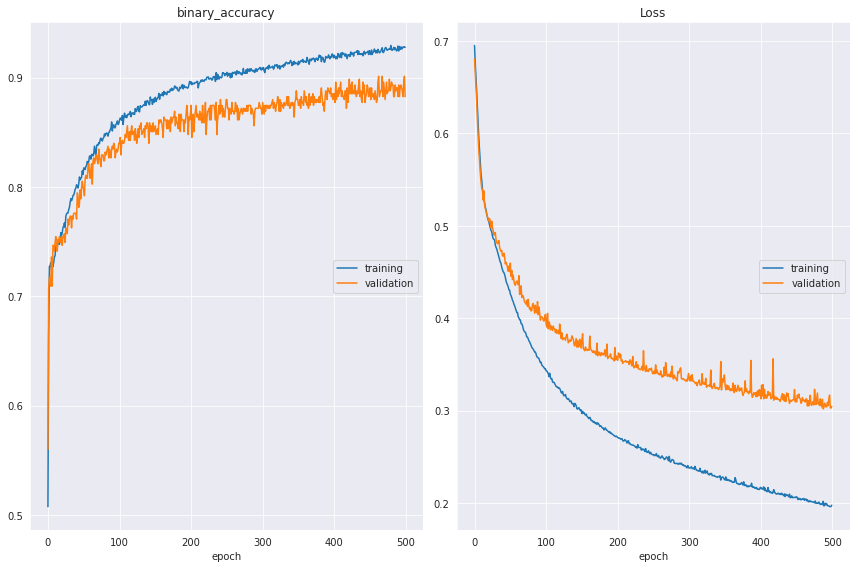

binary_accuracy
	training         	 (min:    0.508, max:    0.929, cur:    0.928)
	validation       	 (min:    0.560, max:    0.901, cur:    0.883)
Loss
	training         	 (min:    0.196, max:    0.695, cur:    0.198)
	validation       	 (min:    0.302, max:    0.680, cur:    0.305)


In [24]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

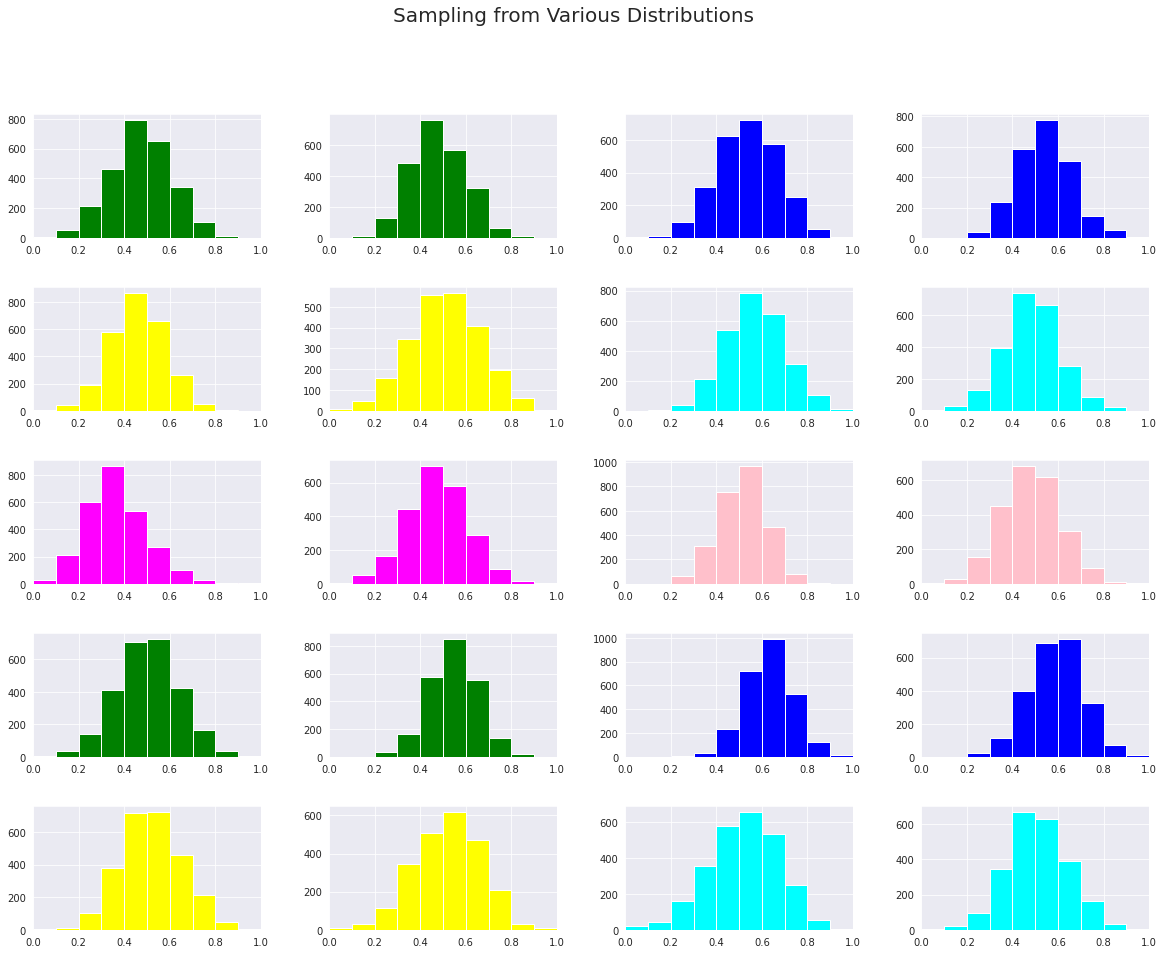

In [25]:
colors_list = ['green','blue','yellow','cyan','magenta','pink']

if config['data']['number_of_variables'] > 4:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
else:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values, verbose=0).ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values, verbose=0).ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [26]:
distribution_parameter_list_list[0][1]

In [27]:
#%load_ext autoreload
#%autoreload 2

In [ ]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  88 tasks      | elapsed: 14.1min
[Parallel(n_jobs=100)]: Done 312 tasks      | elapsed: 32.2min
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed: 55.9min
[Parallel(n_jobs=100)]: Done 952 tasks      | elapsed: 87.2min
[Parallel(n_jobs=100)]: Done 1368 tasks      | elapsed: 122.4min
[Parallel(n_jobs=100)]: Done 1848 tasks      | elapsed: 164.6min
[Parallel(n_jobs=100)]: Done 2392 tasks      | elapsed: 213.3min
[Parallel(n_jobs=100)]: Done 3000 tasks      | elapsed: 267.7min
[Parallel(n_jobs=100)]: Done 3672 tasks      | elapsed: 327.2min
[Parallel(n_jobs=100)]: Done 4408 tasks      | elapsed: 392.8min
[Parallel(n_jobs=100)]: Done 5208 tasks      | elapsed: 464.7min
[Parallel(n_jobs=100)]: Done 6072 tasks      | elapsed: 538.8min
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fe2225fc9d0>
Traceback (most recent call last):
  File "/work/pkoeni

In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()